Missing values in each column:
 Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64
Rows before removing outliers: 3999, after removing outliers: 2875


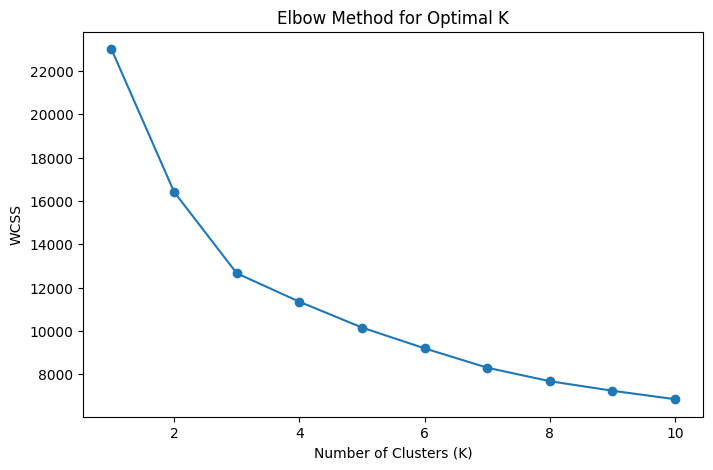

K-Means Silhouette Score: 0.3208


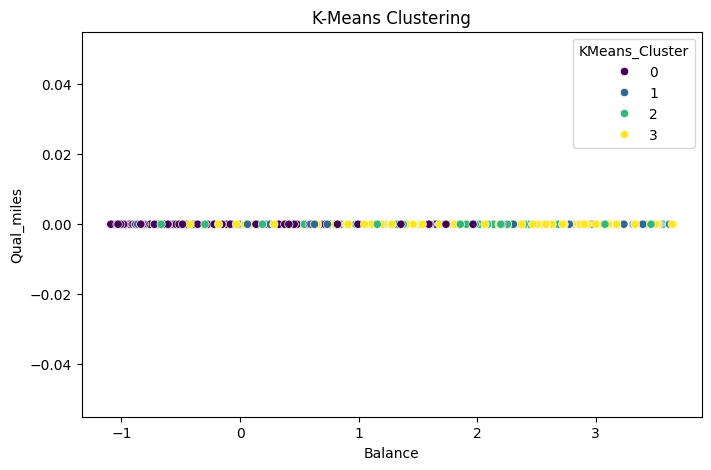

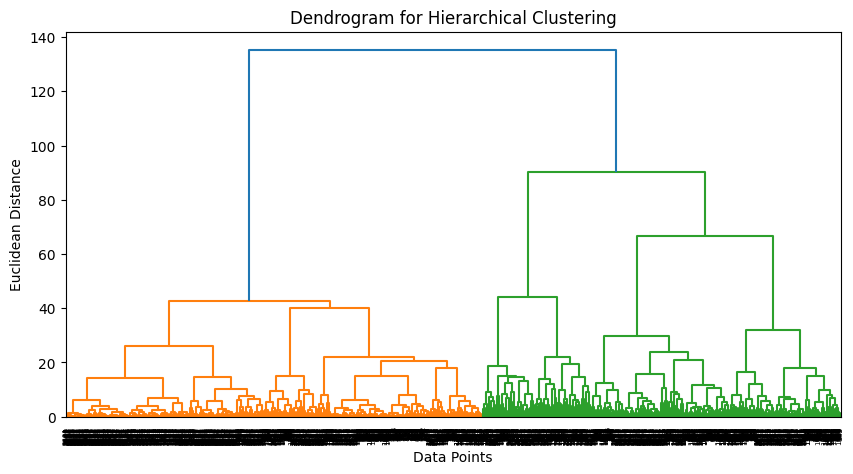

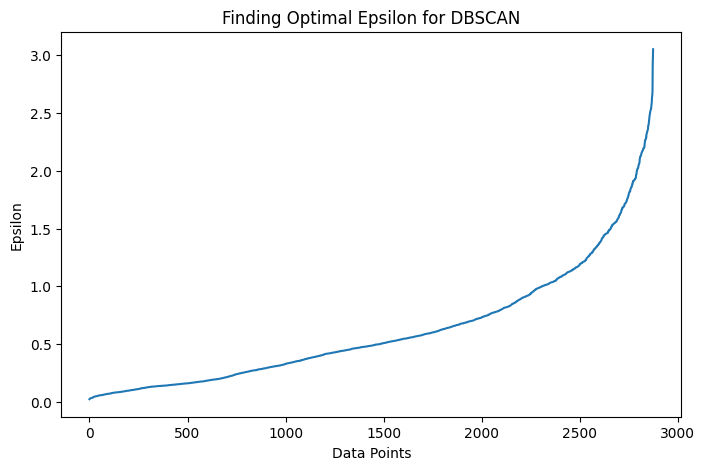

DBSCAN Silhouette Score: 0.0183


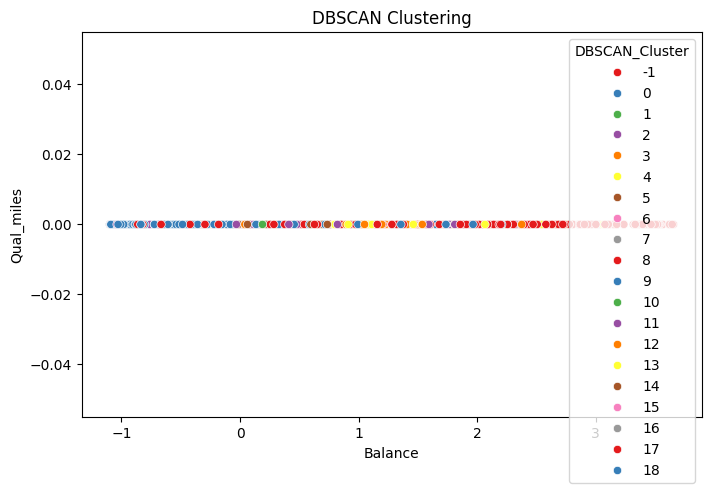


K-Means Cluster Distribution:
 KMeans_Cluster
0    1543
3     539
1     453
2     340
Name: count, dtype: int64

Hierarchical Cluster Distribution:
 Hierarchical_Cluster
1    1547
3     515
2     411
0     402
Name: count, dtype: int64

DBSCAN Cluster Distribution:
 DBSCAN_Cluster
 0     1225
-1      726
 4      202
 2      179
 5      130
 3       83
 1       75
 9       59
 11      54
 8       44
 10      32
 17      14
 7        9
 15       8
 6        8
 13       7
 16       7
 12       5
 18       5
 14       3
Name: count, dtype: int64

Cluster-wise feature analysis:
                      Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  \
KMeans_Cluster                                                              
0.0             52353.387755         0.0   1.945874        1.0        1.0   
1.0             54489.808725         0.0   1.989933        1.0        1.0   
2.0             51161.524444         0.0   2.008889        1.0        1.0   
3.0             54650.521490     

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# Load Excel file (Ensure you select the correct sheet with data)
file_path = "EastWestAirlines.xlsx"  # Update with the correct file path
df = pd.read_excel(file_path, sheet_name="data")  # Adjust sheet_name if needed

# Drop unnecessary columns
df = df.drop(columns=["ID#"], errors="ignore")

# Handling missing values (No missing values found in your data)
print("Missing values in each column:\n", df.isnull().sum())

# Remove Outliers using IQR method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"Rows before removing outliers: {df.shape[0]}, after removing outliers: {df_cleaned.shape[0]}")

# Feature Scaling
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)

# -------------- K-MEANS CLUSTERING ----------------
# Find optimal K using Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal K")
plt.show()

# Applying K-Means with K=4 (from your results)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_scaled["KMeans_Cluster"] = kmeans.fit_predict(df_scaled)

# Silhouette Score for K-Means
kmeans_silhouette = silhouette_score(df_scaled.drop(columns=["KMeans_Cluster"]), df_scaled["KMeans_Cluster"])
print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f}")

# Scatter Plot of K-Means Clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_scaled.iloc[:, 0], y=df_scaled.iloc[:, 1], hue=df_scaled["KMeans_Cluster"], palette="viridis")
plt.title("K-Means Clustering")
plt.xlabel(df_scaled.columns[0])
plt.ylabel(df_scaled.columns[1])
plt.show()

# -------------- HIERARCHICAL CLUSTERING ----------------
# Plot Dendrogram
plt.figure(figsize=(10, 5))
dendrogram = sch.dendrogram(sch.linkage(df_scaled, method="ward"))
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

# Applying Hierarchical Clustering with 4 clusters
hc = AgglomerativeClustering(n_clusters=4, metric="euclidean", linkage="ward")
df_scaled["Hierarchical_Cluster"] = hc.fit_predict(df_scaled)


# -------------- DBSCAN CLUSTERING ----------------
# Finding optimal epsilon using Nearest Neighbors distance plot
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)
distances = np.sort(distances[:, 4], axis=0)

# Plot K-distance graph
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Data Points")
plt.ylabel("Epsilon")
plt.title("Finding Optimal Epsilon for DBSCAN")
plt.show()

# Applying DBSCAN with estimated parameters
dbscan = DBSCAN(eps=0.7, min_samples=5)  # Adjust based on K-distance plot
df_scaled["DBSCAN_Cluster"] = dbscan.fit_predict(df_scaled)

# Silhouette Score for DBSCAN
dbscan_silhouette = silhouette_score(df_scaled.drop(columns=["DBSCAN_Cluster"]), df_scaled["DBSCAN_Cluster"])
print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.4f}")

# Scatter Plot for DBSCAN
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_scaled.iloc[:, 0], y=df_scaled.iloc[:, 1], hue=df_scaled["DBSCAN_Cluster"], palette="Set1")
plt.title("DBSCAN Clustering")
plt.xlabel(df_scaled.columns[0])
plt.ylabel(df_scaled.columns[1])
plt.show()

# -------------- CLUSTER DISTRIBUTIONS ----------------
print("\nK-Means Cluster Distribution:\n", df_scaled["KMeans_Cluster"].value_counts())
print("\nHierarchical Cluster Distribution:\n", df_scaled["Hierarchical_Cluster"].value_counts())
print("\nDBSCAN Cluster Distribution:\n", df_scaled["DBSCAN_Cluster"].value_counts())

# Cluster-wise Feature Analysis
print("\nCluster-wise feature analysis:\n", df_cleaned.groupby(df_scaled["KMeans_Cluster"]).mean())

